<a href="https://colab.research.google.com/github/mz1119/shaker-level-detection-model/blob/main/Outline_Mask_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount drive, allows access to folder in google drive
#for this project, i made a folder in my drive called Blue Hill and worked out of that folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-iiydr6_3
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-iiydr6_3
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263902 sha256=ffaa14a787f28aeb56616c983583c895a756d26d810470d427b41d8db47765f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-qmzmyz8g/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


L
True True False False


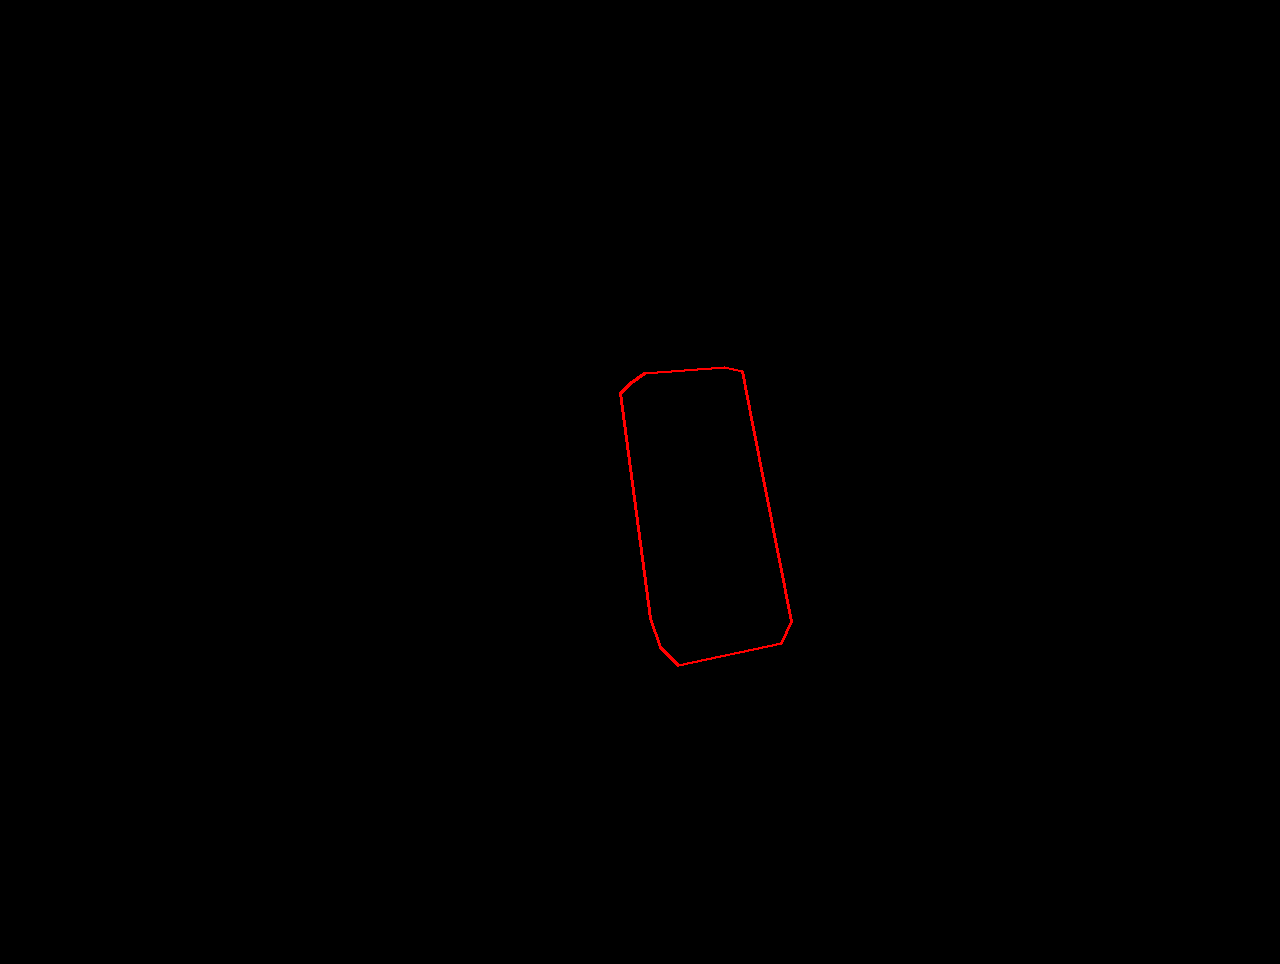

In [ ]:
# this cell displays mask a mask saved in drive, just to see if things are working
from PIL import Image
import numpy as np

with Image.open("/content/drive/My Drive/Blue Hill/Outline_Masks/outline_mask_20210615_162909_Image.PNG") as im:
    load_variable = im.load()
print(im.mode) #should be L
mask_list = np.array(im)
#check if correct pixels values in list, each class has different value with background as 0 and next class as 1 and so on
#should print true, true, false, false
print(0 in mask_list, 1 in mask_list, 2 in mask_list, 3 in mask_list)

#since 1 is so close to 0, putpallete makes the difference more visible
im.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    0, 255, 0, # index 2 is green
])

im

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image

class myDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Coffee_Shaker_Images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Outline_Masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "Coffee_Shaker_Images", self.imgs[idx])
        mask_path = os.path.join(self.root, "Outline_Masks", self.masks[idx])
        
        img = Image.open(img_path).convert("RGB")
        # mask not converted to RGB, color mode should be "L", only has one channel, greyscale
        # each instance/class corresponds to different pixel calue
        # with 0 being background
        
        #Image.open is a bit weird, without load it opens as RGB
        #load fully opens the picture, making it "L" mode and not losing any data
        with Image.open(mask_path) as mask:
          load_variable = mask.load()
          mask = mask
        
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = myDataset("/content/drive/My Drive/Blue Hill/")
dataset[0]

(<PIL.Image.Image image mode=RGB size=1280x964 at 0x7F6BC17787D0>,
 {'area': tensor([62814.]),
  'boxes': tensor([[601., 228., 775., 589.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 30213, done.
remote: Counting objects: 100% (2756/2756), done.
remote: Compressing objects: 100% (714/714), done.
remote: Total 30213 (delta 2100), reused 2591 (delta 1989), pack-reused 27457
Receiving objects: 100% (30213/30213), 38.10 MiB | 25.70 MiB/s, done.
Resolving deltas: 100% (22710/22710), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = myDataset("/content/drive/My Drive/Blue Hill/", get_transform(train=True))
dataset_test = myDataset("/content/drive/My Drive/Blue Hill/", get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
#  dataset has 2 classes
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

cuda


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model, "/content/drive/My Drive/Blue Hill/Saved_Outline_Mask_Model.pth")
print('model saved')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [  0/383]  eta: 0:16:23  lr: 0.000036  loss: 16.2730 (16.2730)  loss_classifier: 0.9539 (0.9539)  loss_box_reg: 0.1387 (0.1387)  loss_mask: 15.1583 (15.1583)  loss_objectness: 0.0204 (0.0204)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 2.5677  data: 1.6472  max mem: 2162
Epoch: [0]  [ 10/383]  eta: 0:04:17  lr: 0.000298  loss: 3.2729 (6.4957)  loss_classifier: 0.6853 (0.6155)  loss_box_reg: 0.0918 (0.1051)  loss_mask: 2.4725 (5.7419)  loss_objectness: 0.0256 (0.0291)  loss_rpn_box_reg: 0.0030 (0.0040)  time: 0.6895  data: 0.1624  max mem: 2435
Epoch: [0]  [ 20/383]  eta: 0:03:37  lr: 0.000559  loss: 0.6579 (3.6947)  loss_classifier: 0.1362 (0.3760)  loss_box_reg: 0.0903 (0.0984)  loss_mask: 0.3647 (3.1886)  loss_objectness: 0.0232 (0.0275)  loss_rpn_box_reg: 0.0028 (0.0041)  time: 0.5014  data: 0.0136  max mem: 2435
Epoch: [0]  [ 30/383]  eta: 0:03:21  lr: 0.000821  loss: 0.4673 (2.6416)  loss_classifier: 0.1045 (0.2883)  loss_box_reg: 0.0990 (0.0984)  loss_mask: 0.2763 (2.22